In [18]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
import csv
import pandas as pd
import re
import gzip
from rdkit.Chem.Scaffolds import MurckoScaffold

In [7]:
mols = []
with open("../data/chembl_mtor_ic50.csv") as inp:
    mols.extend([row for row in csv.DictReader(inp, delimiter=";", quotechar='"')])
    for m in mols:
        m["rdmol"] = Chem.MolFromSmiles(m["Smiles"])
        m["smiles"] = m["Smiles"]
        m["source"] = "mtor"
        m["pChEMBL_value"] = float(m["pChEMBL Value"]) if float_pattern.match(m["pChEMBL Value"]) else 0
        m["fps"] = Chem.GetMorganFingerprintAsBitVect(m["rdmol"],2,nBits=1024)

In [8]:
%%capture
# %%capture hides stderr (and maybe all output)
# same for drugbank
mols.extend([{"rdmol": m,
             "source": "drugbank",
             "smiles": Chem.MolToSmiles(m),
              "rdmol": m,
             "pChEMBL_value": 0,
             "fps": Chem.GetMorganFingerprintAsBitVect(m, 2, nBits=1024),
             #**{f[0]: f[1](m) for f in lip_func}
            } for m in Chem.SDMolSupplier("../data/drugbank.sdf") if m
           ])

In [10]:
with gzip.open('../data/rock1/actives_final.sdf.gz', 'r') as sdf:
    suppl = Chem.ForwardSDMolSupplier(sdf)
    for i,mol in enumerate(suppl):
        if mol:
            mols.append({
                 "source":"active_rock",
                 "rdmol": mol,
                "smiles": Chem.MolToSmiles(mol),
                 "pChEMBL_value": 0,
                 # Chem.MolToInchiKey(mol),
                 "fps": Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
                }
            )
with gzip.open('../data/rock1/decoys_final.sdf.gz', 'r') as sdf:
    suppl = Chem.ForwardSDMolSupplier(sdf)
    for i,mol in enumerate(suppl):
        if mol:
            mols.append({
                 "source":"decoy_rock",
                 "smiles": Chem.MolToSmiles(mol),
                 "rdmol": mol,
                 "pChEMBL_value": 0,
                 # Chem.MolToInchiKey(mol),
                 "fps": Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
                }
            )
with open('../data/rock1/rock1_ic50_chembl.csv', 'r') as inp:
    reader = csv.reader(inp, delimiter=";")
    header = next(reader)
    for row in reader:
        try:
            mol = Chem.MolFromSmiles(row[7])
        except Exception as e:
            print(row)
            raise e
        if mol:
            mols.append({
                 "source":"chembl_rock",
                 "rdmol": mol,
                "smiles": Chem.MolToSmiles(mol),
                 "pChEMBL_value": 0,
                 # Chem.MolToInchiKey(mol),
                 "fps": Chem.GetMorganFingerprintAsBitVect(mol,2,nBits=1024)
                }
            )

In [11]:
# let's work with Pandas dataframe
df = pd.DataFrame(mols, columns=["smiles","source", "rdmol", "fps", "pChEMBL_value"])
# adds index as normal column
df.reset_index(level=0, inplace=True)

In [13]:
df

,index,smiles,source,rdmol,fps,pChEMBL_value
0,0,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",7.35
1,1,CC(=O)Nc1nc2ccc(-c3ccnc(OCc4cccc(C)c4)n3)cc2s1,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
2,2,COc1cccc(COc2nccc(-c3ccc4nc(NC(C)=O)sc4c3)n2)c1,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
3,3,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.14
4,4,CC(=O)Nc1nc2ccc(-c3ccnc(N(C)S(=O)(=O)c4ccccc4F...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.00
...,...,...,...,...,...,...
19719,19719,COc1cccc([C@@H](C)NC(=O)c2ccc3c(c2)COc2cnccc2-...,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
19720,19720,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncn3)cc2NCC...,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
19721,19721,C[C@@H](NC(=O)Nc1cc2[nH]ncc2c(CO)n1)c1ccccc1,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00
19722,19722,COc1cc(NC(=O)[C@H](O)c2ccccc2Cl)ccc1-c1cn[nH]c1,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00


In [36]:
def mol_to_scaffold_smiles(mol):
    scaff = MurckoScaffold.GetScaffoldForMol(mol)
    Chem.rdmolops.RemoveStereochemistry(scaff)
    return Chem.MolToSmiles(scaff)

In [37]:
df['murcko_mol'] = df['rdmol'].apply(lambda x: mol_to_scaffold_smiles(x))
df

,index,smiles,source,rdmol,fps,pChEMBL_value,murcko_mol,generic_mol
0,0,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",7.35,O=S(=O)(Nc1nccc(-c2ccc3ncsc3c2)n1)c1ccccc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
1,1,CC(=O)Nc1nc2ccc(-c3ccnc(OCc4cccc(C)c4)n3)cc2s1,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,c1ccc(COc2nccc(-c3ccc4ncsc4c3)n2)cc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
2,2,COc1cccc(COc2nccc(-c3ccc4nc(NC(C)=O)sc4c3)n2)c1,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,c1ccc(COc2nccc(-c3ccc4ncsc4c3)n2)cc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
3,3,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.14,O=S(=O)(Nc1nccc(-c2ccc3ncsc3c2)n1)c1ccccc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
4,4,CC(=O)Nc1nc2ccc(-c3ccnc(N(C)S(=O)(=O)c4ccccc4F...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.00,O=S(=O)(Nc1nccc(-c2ccc3ncsc3c2)n1)c1ccccc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
...,...,...,...,...,...,...,...,...
19719,19719,COc1cccc([C@@H](C)NC(=O)c2ccc3c(c2)COc2cnccc2-...,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(NCc1ccccc1)c1ccc2c(c1)COc1cnccc1-2,C1CCC(CCCC2CCC3C(CCC4CCCCC43)C2)CC1
19720,19720,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncn3)cc2NCC...,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(NCc1ccccc1)c1ccc(-c2ccncn2)cc1,C1CCC(CCCC2CCC(C3CCCCC3)CC2)CC1
19721,19721,C[C@@H](NC(=O)Nc1cc2[nH]ncc2c(CO)n1)c1ccccc1,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(NCc1ccccc1)Nc1cc2[nH]ncc2cn1,C1CCC(CCCCC2CCC3CCCC3C2)CC1
19722,19722,COc1cc(NC(=O)[C@H](O)c2ccccc2Cl)ccc1-c1cn[nH]c1,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(Cc1ccccc1)Nc1ccc(-c2cn[nH]c2)cc1,C1CCC(CCCC2CCC(C3CCCC3)CC2)CC1


In [22]:
def mol_to_generic_scaffold_smiles(mol):
    try:
        scaff = MurckoScaffold.GetScaffoldForMol(mol)
        Chem.rdmolops.RemoveStereochemistry(scaff)
        scaff = MurckoScaffold.MakeScaffoldGeneric(scaff)
        scaff = MurckoScaffold.GetScaffoldForMol(scaff)
        return Chem.MolToSmiles(scaff)
    except:
        return 'C'

In [59]:
df['generic_mol'] = df['rdmol'].apply(lambda x: mol_to_generic_scaffold_smiles(x))
df

[13:47:42] Explicit valence for atom # 48 C, 5, is greater than permitted
[13:47:42] Explicit valence for atom # 41 C, 5, is greater than permitted
[13:47:43] Explicit valence for atom # 30 C, 6, is greater than permitted
[13:47:43] Explicit valence for atom # 14 C, 10, is greater than permitted
[13:47:44] Explicit valence for atom # 28 C, 5, is greater than permitted
[13:47:44] Explicit valence for atom # 30 C, 6, is greater than permitted


,index,smiles,source,rdmol,fps,pChEMBL_value,murcko_mol,generic_mol
0,0,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccccc4F)n3...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",7.35,O=S(=O)(Nc1nccc(-c2ccc3ncsc3c2)n1)c1ccccc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
1,1,CC(=O)Nc1nc2ccc(-c3ccnc(OCc4cccc(C)c4)n3)cc2s1,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,c1ccc(COc2nccc(-c3ccc4ncsc4c3)n2)cc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
2,2,COc1cccc(COc2nccc(-c3ccc4nc(NC(C)=O)sc4c3)n2)c1,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,c1ccc(COc2nccc(-c3ccc4ncsc4c3)n2)cc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
3,3,CC(=O)Nc1nc2ccc(-c3ccnc(NS(=O)(=O)c4ccc(F)cc4)...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6.14,O=S(=O)(Nc1nccc(-c2ccc3ncsc3c2)n1)c1ccccc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
4,4,CC(=O)Nc1nc2ccc(-c3ccnc(N(C)S(=O)(=O)c4ccccc4F...,mtor,<rdkit.Chem.rdchem.Mol object at 0x00000233B3F...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...",0.00,O=S(=O)(Nc1nccc(-c2ccc3ncsc3c2)n1)c1ccccc1,C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1
...,...,...,...,...,...,...,...,...
19719,19719,COc1cccc([C@@H](C)NC(=O)c2ccc3c(c2)COc2cnccc2-...,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(NCc1ccccc1)c1ccc2c(c1)COc1cnccc1-2,C1CCC(CCCC2CCC3C(CCC4CCCCC43)C2)CC1
19720,19720,COc1cccc([C@@H](C)NC(=O)c2ccc(-c3ccncn3)cc2NCC...,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(NCc1ccccc1)c1ccc(-c2ccncn2)cc1,C1CCC(CCCC2CCC(C3CCCCC3)CC2)CC1
19721,19721,C[C@@H](NC(=O)Nc1cc2[nH]ncc2c(CO)n1)c1ccccc1,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(NCc1ccccc1)Nc1cc2[nH]ncc2cn1,C1CCC(CCCCC2CCC3CCCC3C2)CC1
19722,19722,COc1cc(NC(=O)[C@H](O)c2ccccc2Cl)ccc1-c1cn[nH]c1,chembl_rock,<rdkit.Chem.rdchem.Mol object at 0x00000233D43...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.00,O=C(Cc1ccccc1)Nc1ccc(-c2cn[nH]c2)cc1,C1CCC(CCCC2CCC(C3CCCC3)CC2)CC1


In [38]:
category_scaffolds = df['murcko_mol'].value_counts()

In [39]:
category_scaffolds

                                                 982
c1ccccc1                                         835
O=C(NCc1ccccc1)c1ccc(-c2cn[nH]c2)cc1             256
c1ccc(-c2ccc3c(N4CCOCC4)nc(N4CCOCC4)nc3n2)cc1    171
C1CCOCC1                                         132
                                                ... 
O=C1CC(CCc2cccc(-c3ccccc3)c2)N=CN1                 1
C1=CN(CCNCC2CCCNC2)CC(NCCc2ccccn2)=N1              1
O=c1c(-c2ccc3ncncc3c2)cccn1-c1ccc2c(c1)NCC2        1
[BH2-]1n2cccc2C=C2C=CC=[N+]12                      1
O=C(NCc1ccccc1)Nc1cc2[nH]ncc2cn1                   1
Name: murcko_mol, Length: 9443, dtype: int64

In [45]:
df[df.source == "mtor"]['murcko_mol'].value_counts()

c1ccc(-c2ccc3c(N4CCOCC4)nc(N4CCOCC4)nc3n2)cc1                             171
O=C(c1ccc(-c2ncncc2C#Cc2cccnc2)cc1)N1CCNCC1                               132
c1cncc(Nc2ncccc2-c2ncncn2)c1                                               99
c1ccc(-c2n[nH]c3ncncc23)cc1                                                79
c1cncc(Nc2ncc(CN3CCNCC3)cc2-c2ncncn2)c1                                    67
                                                                         ... 
c1ccc(CN2CCC(n3ncc4c(N5CCOCC5)nc(-c5cccc6[nH]ccc56)nc43)CC2)cc1             1
O=C(Nc1ccc(C(=O)N2CCNCC2)cc1)Nc1ccc(-c2nc(=O)nc(N3CCOCC3)[nH]2)cc1          1
O=C(Nc1cccc(-c2ccnc3cc(-c4ccncc4)nn23)c1)c1ccccc1                           1
O=C(Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5ccccc5)CC4)c3n2)cc1)Nc1cccnc1      1
c1ccc(-c2cn[nH]c2)cc1                                                       1
Name: murcko_mol, Length: 1489, dtype: int64

In [47]:
mtor_scaffolds = pd.DataFrame(df[df.source == "mtor"]['murcko_mol'].value_counts())
mtor_scaffolds['ratio'] = mtor_scaffolds['murcko_mol'] / mtor_scaffolds['murcko_mol'].sum()
mtor_scaffolds

,murcko_mol,ratio
c1ccc(-c2ccc3c(N4CCOCC4)nc(N4CCOCC4)nc3n2)cc1,171,0.037206
O=C(c1ccc(-c2ncncc2C#Cc2cccnc2)cc1)N1CCNCC1,132,0.028721
c1cncc(Nc2ncccc2-c2ncncn2)c1,99,0.021540
c1ccc(-c2n[nH]c3ncncc23)cc1,79,0.017189
c1cncc(Nc2ncc(CN3CCNCC3)cc2-c2ncncn2)c1,67,0.014578
...,...,...
c1ccc(CN2CCC(n3ncc4c(N5CCOCC5)nc(-c5cccc6[nH]ccc56)nc43)CC2)cc1,1,0.000218
O=C(Nc1ccc(C(=O)N2CCNCC2)cc1)Nc1ccc(-c2nc(=O)nc(N3CCOCC3)[nH]2)cc1,1,0.000218
O=C(Nc1cccc(-c2ccnc3cc(-c4ccncc4)nn23)c1)c1ccccc1,1,0.000218
O=C(Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5ccccc5)CC4)c3n2)cc1)Nc1cccnc1,1,0.000218


In [61]:
mtor_generic_scaffolds = pd.DataFrame(df[df.source == "mtor"]['generic_mol'].value_counts())
mtor_generic_scaffolds['ratio'] = mtor_generic_scaffolds['generic_mol'] / mtor_generic_scaffolds['generic_mol'].sum()
mtor_generic_scaffolds

,generic_mol,ratio
C1CCC(C2CCC3C(C2)CC(C2CCCCC2)CC3C2CCCCC2)CC1,283,0.061575
C1CCC(CCC2CCCCC2C2CCC(CC3CCCCC3)CC2)CC1,263,0.057224
C1CCC(CCC2CCCCC2C2CCCCC2)CC1,190,0.041340
C1CCC(C2CC3CCCC3C(C3CCCCC3)C2)CC1,135,0.029373
C1CCC(CC2CCCCC2C2CCCCC2)CC1,133,0.028938
...,...,...
C1CCC(CC2CCC(CCCC3CCC4CC(CC5CCC6CCCCC65)CC4C3)CC2)CC1,1,0.000218
C1CCC(CCCC2CCC(C3CC(C4CCCCC4)C4CCC(CCC5CCCC5)C4C3)CC2)CC1,1,0.000218
C1CCC(C2CCC(CC3CCCC(C4C(CC5CCCC5)CC5CCCCC54)C3)CC2)CC1,1,0.000218
C1CCC(CCCC2CCC3CC(CC4CCC5CCCC(C6CC7CCC6CC7)C54)CC3C2)CC1,1,0.000218


In [41]:
df[df.source == "drugbank"]['murcko_mol'].value_counts()

                                                        982
c1ccccc1                                                637
C1CCOCC1                                                131
c1ncc2ncn(C3CCCO3)c2n1                                  101
c1ccc2ccccc2c1                                           49
                                                       ... 
O=c1[nH]cnc2c1N1CN(c3ccc(CCCCCOC4CCCO4)cc3)CC1CN2         1
O=C(CNC(=O)c1ccccc1)NC(Cc1ccccc1)C(=O)NCCc1ccccc1         1
c1ccc2c(c1)Cc1c-2n[nH]c1-c1ccncc1                         1
C1=CC(NC2CCC(OC3CCC(OCC4CCCCO4)OC3)OC2)CCC1               1
O=c1[nH]cnc2c1ncn2C1CCCO1.c1ccccc1.c1ccccc1.c1ccccc1      1
Name: murcko_mol, Length: 3250, dtype: int64

In [50]:
drugbank_scaffolds = pd.DataFrame(df[df.source == "drugbank"]['murcko_mol'].value_counts())
drugbank_scaffolds['ratio'] = drugbank_scaffolds['murcko_mol'] / drugbank_scaffolds['murcko_mol'].sum()
drugbank_scaffolds

,murcko_mol,ratio
,982,0.137979
c1ccccc1,637,0.089504
C1CCOCC1,131,0.018407
c1ncc2ncn(C3CCCO3)c2n1,101,0.014191
c1ccc2ccccc2c1,49,0.006885
...,...,...
O=c1[nH]cnc2c1N1CN(c3ccc(CCCCCOC4CCCO4)cc3)CC1CN2,1,0.000141
O=C(CNC(=O)c1ccccc1)NC(Cc1ccccc1)C(=O)NCCc1ccccc1,1,0.000141
c1ccc2c(c1)Cc1c-2n[nH]c1-c1ccncc1,1,0.000141
C1=CC(NC2CCC(OC3CCC(OCC4CCCCO4)OC3)OC2)CCC1,1,0.000141


In [62]:
drugbank_generic_scaffolds = pd.DataFrame(df[df.source == "drugbank"]['generic_mol'].value_counts())
drugbank_generic_scaffolds['ratio'] = drugbank_generic_scaffolds['generic_mol'] / drugbank_generic_scaffolds['generic_mol'].sum()
drugbank_generic_scaffolds

,generic_mol,ratio
C1CCCCC1,1039,0.145988
,982,0.137979
C1CCC2CCCC2C1,192,0.026978
C1CCCC1,188,0.026416
C1CCC(CC2CCCCC2)CC1,182,0.025573
...,...,...
C(CCCCC1CCCC1)CCCC1CCCCC1,1,0.000141
C1CCC(CCC2CCCC(CC3CCCC(C4CCCCC4)C3)C2)CC1,1,0.000141
C1CCC(CCC2CCC3CC(CC4CCCC(CC5CCC6CC(CCC7CCCCC7)CCC6C5)C4)CCC3C2)CC1,1,0.000141
C1CC2CCC1CC2,1,0.000141


In [42]:
df[df.source == "chembl_rock"]['murcko_mol'].value_counts()

O=C(NCc1ccccc1)c1ccc(-c2cn[nH]c2)cc1                  256
O=C(NCc1ccccc1)Nc1nc(-c2ccncc2)cs1                    119
O=C(NCCc1ccccc1)c1ccc(-c2cn[nH]c2)cc1                  33
O=C(COc1ccc2c(=O)ccoc2c1)Nc1cccc(NC(=O)c2ccccc2)c1     30
O=C(NCc1ccccc1)c1ccc(-c2ccncc2)cc1                     28
                                                     ... 
O=C(NCc1cccc2[nH]ncc12)c1ccc(-c2cn[nH]c2)cc1            1
c1cc(-c2cnc(N3CCCC3)c(N3CCCCC3)n2)c2cc[nH]c2n1          1
c1nonc1-c1nc2cncc(OCC3CCNC3)c2[nH]1                     1
c1cc2cc(OC3CCNCC3)ccc2cn1                               1
O=C(NCc1ccccc1)Nc1cc2[nH]ncc2cn1                        1
Name: murcko_mol, Length: 469, dtype: int64

In [43]:
df[df.source == "decoy_rock"]['murcko_mol'].value_counts()

c1ccccc1                                               198
C1CCCCC1                                                46
c1ccc(Oc2ccccc2)cc1                                     29
C1=CC2c3ccccc3NC(c3ccccc3)C2C1                          24
O=C(NCCOc1ccccc1)C1CN(C(=O)c2ccccc2)CC12CC[NH2+]CC2     21
                                                      ... 
O=C(CC[NH2+]C1CCCCC1)NN1C(=O)NC2(CCCCC2)C1=O             1
O=C(CCNC(=O)N1CCC2=c3ccccc3=[NH+]C2C1)Nc1nccs1           1
O=S1(=O)CCC(NC=[NH+]Nc2ccccc2)C1                         1
[NH2+]=C1Nc2ncccc2NC12CCN(C(=O)Cc1ccccc1)C2              1
O=C(NCC[NH+]1CCCCCC1)NNC(=O)c1ccccc1                     1
Name: murcko_mol, Length: 4331, dtype: int64

In [44]:
df[df.source == "active_rock"]['murcko_mol'].value_counts()

O=C(Cc1ccccc1)Nc1ccc2c(=O)[nH]ccc2c1                    4
c1cc(NC2CCC[NH2+]C2)c2cc[nH+]cc2c1                      2
c1ccc(C[NH+]2CCCC(Nc3ccc4[nH]ncc4c3)C2)cc1              2
C1=NC(c2ccccn2)=NC(c2ccccc2)C1=CNc1ccc2[nH]ncc2c1       2
c1csc(C[NH+]2CCCC(Nc3ccc4n[nH]cc4c3)C2)c1               2
                                                       ..
c1cc(-c2cnc(N3CCCC3)c(N3CC[NH2+]CC3)n2)c2cc[nH]c2n1     1
c1ccc2c(c1)CC(Nc1nc(Nc3ccncc3)nc(N3CC[NH2+]CC3)n1)C2    1
c1c[nH]c(-c2nccc3[nH]c(-c4cnon4)nc23)c1                 1
c1cc(-c2cnc(N3CCCC3)c(N3CCCCC3)n2)c2cc[nH]c2n1          1
O=S(=O)(CN1CCC[NH2+]CC1)c1cccc2cnccc12                  1
Name: murcko_mol, Length: 140, dtype: int64

In [57]:
mtor_scaffolds.subtract(drugbank_scaffolds).dropna().sort_values('ratio', ascending=False)

,murcko_mol,ratio
c1ccc(-c2n[nH]c3ncncc23)cc1,76.0,0.016767
c1ccc2cc(-c3n[nH]c4ncncc34)ccc2c1,11.0,0.002470
O=C1CCC=CCC(=O)CC(CCC2CCCCC2)OC(=O)C2CCCCN2C(=O)C(=O)C2CCCC(CCC=CC=CC=CCCC1)O2,9.0,0.002189
c1cnc2ccc(-c3n[nH]c4ncncc34)cc2c1,8.0,0.001818
O=c1cc(N2CCOCC2)oc2c(-c3ccccc3)cccc12,8.0,0.001818
c1ccc(-c2nn(C3CCC3)c3ncncc23)cc1,4.0,0.000947
c1ncc2c(-c3cnc4[nH]ccc4c3)nn(C3CCCC3)c2n1,2.0,0.000512
O=C(OCCCc1cccnc1)C1CCCN1,2.0,0.000512
O=C(Nc1ccccc1)c1cnc(Nc2cc(N3CCNCC3)ncn2)s1,1.0,0.000295
O=C1CC=CCCCCC2CCCC(O2)C(=O)C(=O)N2CCCCC2C(=O)OC(C=CC2CCCCC2)CCC1,0.0,0.000154


In [64]:
generic_scaffold_diff = mtor_generic_scaffolds.subtract(drugbank_generic_scaffolds).dropna().sort_values('ratio', ascending=False)

In [76]:
[index for index, content in generic_scaffold_diff[:20].iterrows()]

['C1CCC(CCC2CCCCC2C2CCCCC2)CC1',
 'C1CCC(CC2CCCCC2C2CCCCC2)CC1',
 'C1CCC(C2CCC3CCCCC32)CC1',
 'C1CCC(CCC2CCCC(C3CCC4CCCC4C3)C2)CC1',
 'C1CCC2CC(C3CCC4CCCCC43)CCC2C1',
 'C1CCC(CCC2CCCC(C3CCC4CCCCC4C3)C2)CC1',
 'C1CCC(C2CC(C3CCCCC3)CC(C3CCCCC3)C2)CC1',
 'C1CCC(CC2CCCC(C3CCCC(C4CCCCC4)C3)C2)CC1',
 'C1CCC(CC2CCC3CCC(C4CCCCC4)CC32)CC1',
 'C1CCC(CCC2CCC3CCCCC32)CC1',
 'C1CCC(C2CCC3CCCC(C4CCCCC4)C3C2)CC1',
 'C1CCC(C2CC3CCCCC3C(C3CCCCC3)C2)CC1',
 'C1CCC2CC(CC3CCC4CCCCC43)CC2C1',
 'C1CCC(CC2CCCC3CCC(C4CCCCC4)CC32)CC1',
 'C1CCC(C2CCC3CCC(C4CCCCC4)C3C2)CC1',
 'C1CCC(CC2CCCC(C3CCC4CCCC4C3)C2)CC1',
 'C1CC2CCC(C3CC(C4CCCC4)C4CCCCC34)CC2C1',
 'C1CCCCCCCCCC(CCC2CCCCC2)CCC2CCCCC2CCC2CCCC(CCCCCCCCC1)C2',
 'C1CCC(C2CCCC(C3CCCCC3)C2)CC1',
 'C1CCC(C2CC(C3CCC3)C3CCCCC23)CC1']

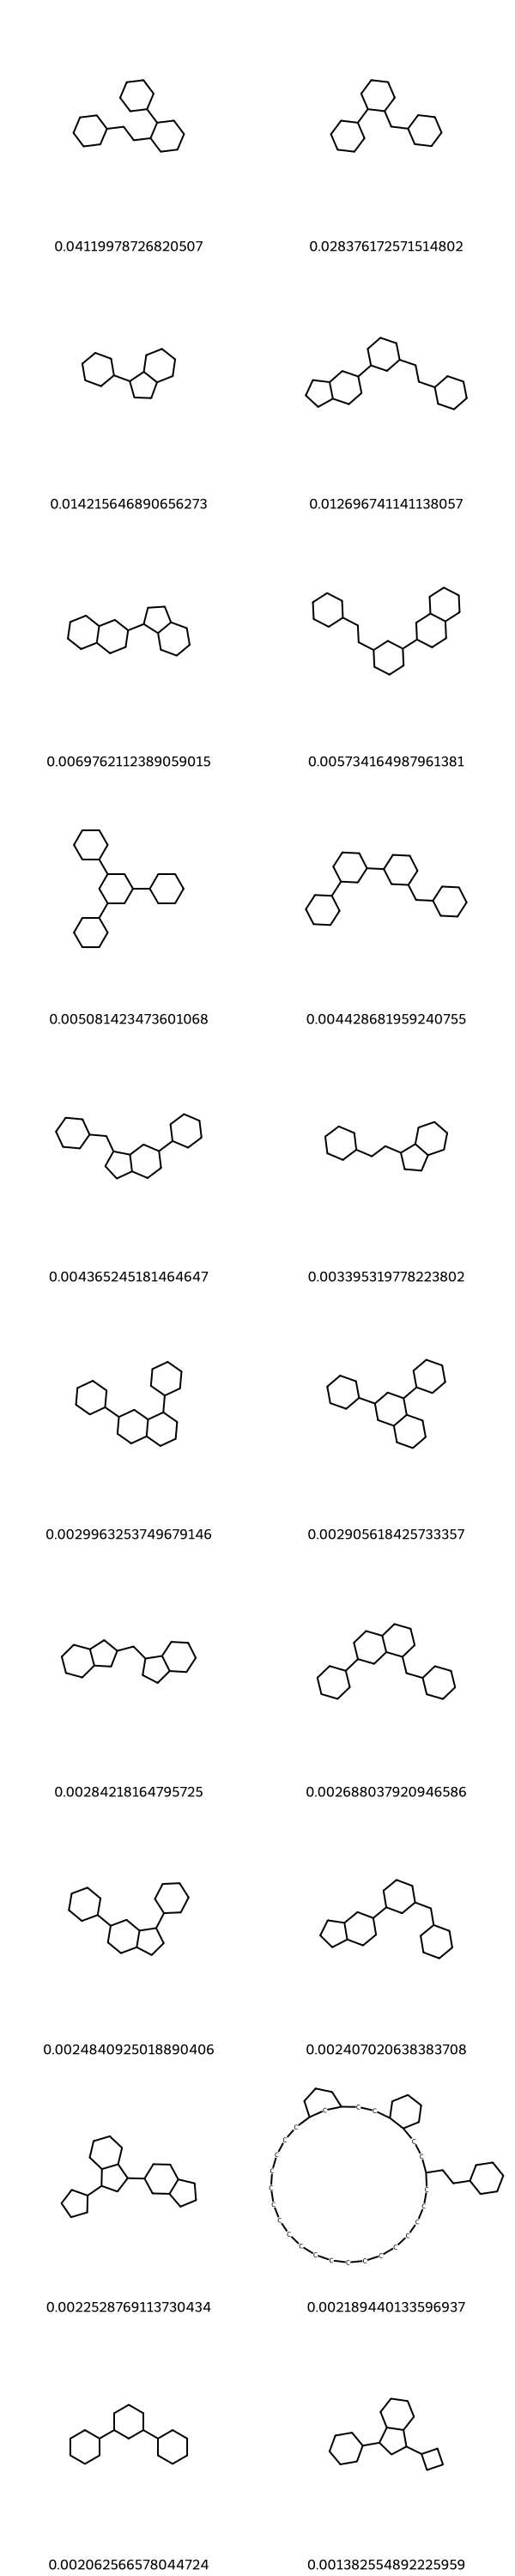

In [79]:
Draw.MolsToGridImage([Chem.MolFromSmiles(idx) for idx, content in generic_scaffold_diff[:20].iterrows()],
                     molsPerRow=2, subImgSize=(300,300),
                     legends=[str(content['ratio']) for idx, content in generic_scaffold_diff[:20].iterrows()])